<a href="https://colab.research.google.com/github/h0806449f/PyTorch/blob/main/DB_08_vision_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **=== 0. 簡介 ===**
1. Set up
2. Raw data & Dataset & Dataloader
4. Replicating vit paper
    1. Equation_1: patch embedding
    2. Equation_2: multi-head attention
    3. Equation_3: multi-layer perceptron
    4. Equation_4
5. Train
6. Transfor for vit
7. Make prediction

# **=== 1. Set up ===**

In [ ]:
!pip install torchinfo

In [ ]:
import torch
from torch import nn
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchinfo import summary

import matplotlib.pyplot as plt

# **=== 2. Raw data, dataset, dataloader ===**

## 2.1 Raw data

In [ ]:
import os
import zipfile
import requests
from pathlib import Path

data_path = Path("data/")
image_path = data_path / "db_image_data"

if image_path.is_dir():
    print(f"[INFO] {image_path} directory already exists.")
else:
    print(f"[INFO] {image_path} not exists, creating ...")
    image_path.mkdir(parents = True, exist_ok = True)

    with open(data_path / "db_image_data.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print(f"[INFO] zip file downloading ...")
        f.write(request.content)

    with zipfile.ZipFile(data_path / "db_image_data.zip", "r") as zip_f:
        print(f"[INFO] zip file unziping ...")
        zip_f.extractall(image_path)

    zip_file_path = data_path / "db_image_data.zip"
    if zip_file_path.exists():
        print(f"[INFO] zip file removing ...")
        os.remove(zip_file_path)

[INFO] data/db_image_data not exists, creating ...
[INFO] zip file downloading ...
[INFO] zip file unziping ...
[INFO] zip file removing ...


## 2.2 Transforms
ViT transforms image into 224*224

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

## 2.3 Dataset

In [ ]:
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dataset = datasets.ImageFolder(root = train_dir, transform = transform)
test_dataset = datasets.ImageFolder(root = test_dir, transform = transform)

## 2.4 Dataloader

In [ ]:
train_dataloader = DataLoader(dataset = train_dataset, batch_size = 32, shuffle = True, drop_last = True)

test_dataloader = DataLoader(dataset = test_dataset, batch_size = 32, shuffle = False, drop_last = True)

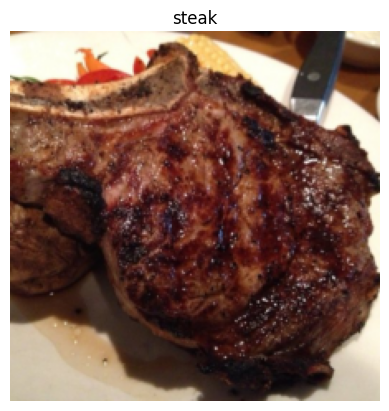

In [ ]:
# Check dataloader
images, labels = next(iter(train_dataloader))
image = images[0]
label = labels[0]

class_names = ['pizza', 'steak', 'sushi']

plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis("off");

# **=== 3. Replicating ViT paper ===**
1. Path embedding : ```x_input = [class_token, image_path1, image_path2, image_path3 ...]``` each patch is learnable
2. Multi-head-attention : MSA wrapping LayerNorm layer(LN) -> (residual connection) :   
    ``` X_output_MSA_block =  MSA_layer((LN_layer(x_input))) + x_output ```
3. Multilayer-perceptron layer : MLP wrapping LayerNorm(LN) -< (residual connection) :   
    ``` x_output_MLP_block = MLP_layer(LN_layer(X_output_MSA_block)) + x_output ```
4. Output layer (y) :   
    ``` y = Linear_layer(LN_layer(x_output_MLP_block[0]))```

## 3.1 圖示

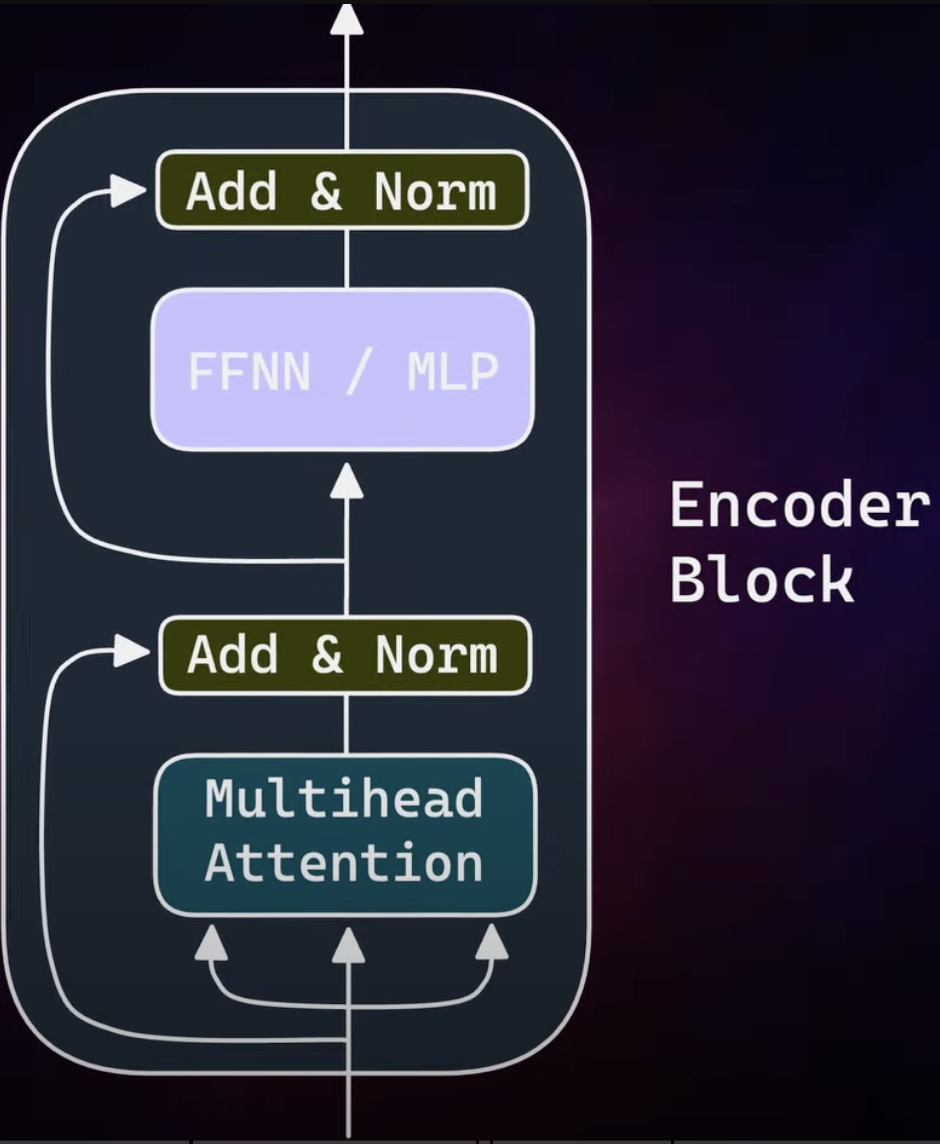

## 3.2 Equation1:
**Split data into patches** `->` **Creating the class** `->` **Position and patch embedding**

### 3.2.1 Split data into patches
patch_embedding 期待的輸入為 H * W * C (2d圖高, 2d圖寬, 色彩通道)  
patch_embedding 期待的輸出為 N * (P*P * C) -> 1D sequence of flattened 2D patches

Split data into patches, explanation step by step

In [27]:
height = 224
width = 224
color_channel = 3
patch_size = 16

number_of_patchs = int(height * width) / patch_size ** 2
print(f"Number of patch with image height={height}, width={width} and patch_size={patch_size} -> {number_of_patchs}")

Number of patch with image height=224, width=224 and patch_size=16 -> 196.0


In [30]:
# Input shape
embedding_layer_input_shape = (height, width, color_channel)

# Output shape
embedding_layer_output_shape = (number_of_patchs, patch_size ** 2 * color_channel)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 2D image flattened into patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 2D image flattened into patches): (196.0, 768)


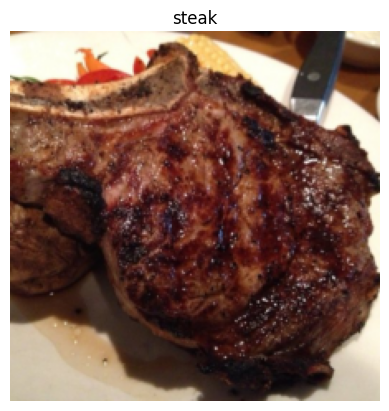

In [32]:
# Single image from train_dataset
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis("off");

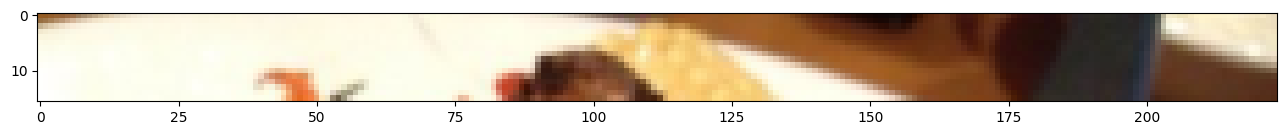

In [41]:
image_permuted = image.permute(1, 2, 0) # (height, width, color_channel)

#
patch_size = 16
plt.figure(figsize = (16, 16))
plt.imshow(image_permuted[:patch_size, :, :]);

Number of patch per row: 14.0,
Each patch's shape: (16 * 16)


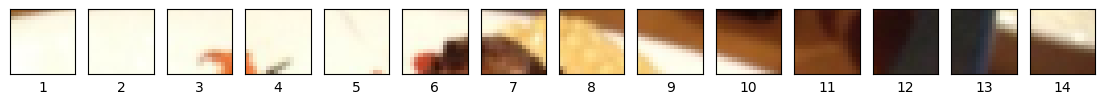

In [48]:
image_size = 224
patch_size = 16
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patch per row: {number_patch},\nEach patch's shape: ({patch_size} * {patch_size})")

fig, axs = plt.subplots(nrows = 1,
                        ncols = image_size // patch_size,
                        figsize = (number_patch, number_patch),
                        sharex = True,
                        sharey = True)

for i, patch in enumerate(range(0, image_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]);
    axs[i].set_xlabel(i+1)
    axs[i].set_xticks([])
    axs[i].set_yticks([])

Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


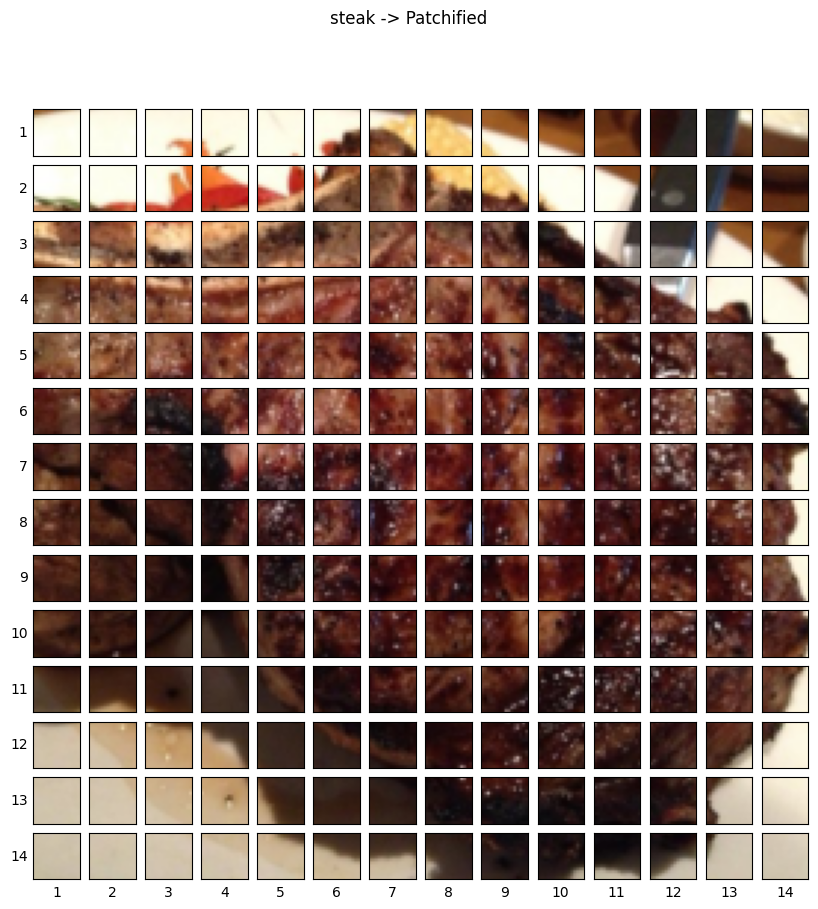

In [52]:
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"

print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")

# Subplot
fig, axs = plt.subplots(nrows=img_size // patch_size,
                        ncols=img_size // patch_size,
                        figsize=(10, 10),
                        sharex=True,
                        sharey=True)

# Loop through height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)): # iter through height
    for j, patch_width in enumerate(range(0, img_size, patch_size)): # iter through width

        # Plot the permuted image patch (image_permuted -> (Height, Width, Color Channels))
        axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, # iterate through height
                                        patch_width:patch_width+patch_size, # iterate through width
                                        :]) # get all color channels

        # Set up label information, remove the ticks for clarity and set labels to outside
        axs[i, j].set_ylabel(i+1,
                             rotation="horizontal",
                             horizontalalignment="right",
                             verticalalignment="center")
        axs[i, j].set_xlabel(j+1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

# Set a super title
fig.suptitle(f"{class_names[label]} -> Patchified")
plt.show()

Each patch through **`one kernel`**

In [53]:
# ViT-Base -> Layers: 12 / Hidden sizeD: 768 / MLP size: 3072 / Heads: 16 / params: 86 Million
from torch import nn

conv2d = nn.Conv2d(in_channels = 3,
                   out_channels = 768,
                   kernel_size = patch_size,
                   stride = patch_size, # 一個patch conv2d 後, 就移動到下一個patch
                   padding = 0)

In [58]:
image_out_of_conv2d = conv2d(image.unsqueeze(dim=0))
print(image_out_of_conv2d.shape)
# batch_size, embedding dimension, feature_map_height, feature_map_width   ->   每一個ptach 都變成 768特徵

torch.Size([1, 768, 14, 14])


Showing random features from indexs: [602, 151, 259, 102, 423]


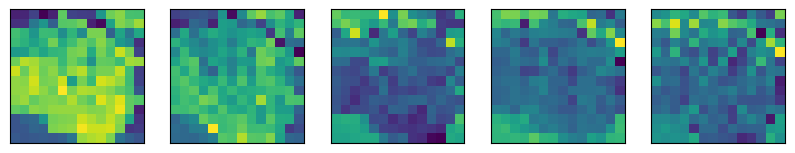

In [64]:
# 隨機從 768 中 挑 5 個特徵 檢視
import random

random_idx = random.sample(range(0, 768), k=5)
print(f"Showing random features from indexs: {random_idx}")

fig, axs = plt.subplots(nrows = 1, ncols = 5, figsize = (10, 10))

for i, idx in enumerate(random_idx):
    image_in_768 = image_out_of_conv2d[:, idx, :, :]
    axs[i].imshow(image_in_768.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [78]:
# 整張圖: 經過conv2d(in=3, out=768) 由RGB三通道 -> 768通道
# 各通道: 經過 kernel_size=16*16 & stride 16 後, 變成 一個tensor 14 * 14
# Flatten: 768通道, 196

# nn.Flatten()
flatten = nn.Flatten(start_dim = 2, end_dim = 3) # 將index 從2開始到3 的維度一維化

#
image_out_of_conv2d_and_flatten = flatten(image_out_of_conv2d)

In [79]:
print(f"Original image shape: {image.shape}")
print(f"Image feature map shape: {image_out_of_conv2d.shape}")
print(f"Flatten image feature map shape: {image_out_of_conv2d_and_flatten.shape}")

Original image shape: torch.Size([3, 224, 224])
Image feature map shape: torch.Size([1, 768, 14, 14])
Flatten image feature map shape: torch.Size([1, 768, 196])


In [89]:
# 使其符合指定輸出 shape
shaped_image_out_of_conv2d_and_flatten = image_out_of_conv2d_and_flatten.permute(0, 2, 1)
print(shaped_image_out_of_conv2d_and_flatten.shape)

# 從 768 種線性特徵中挑出其中一種
single_flattened_feature_map = shaped_image_out_of_conv2d_and_flatten[:, :, 0]

torch.Size([1, 196, 768])


In [ ]:
"""
目前我們已經將一張 2維彩色圖片 轉換為: 1D learnable embedding vector
"""

### 3.2.2 Creating class token embedding

## 3.3 Equation 2:

## 3.4 Equation 3:

## 3.5 Equation 4:

# **=== 4. temp ===**